In [30]:
import matplotlib

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scvelo as scv
import cellrank as cr

In [2]:
from matplotlib import font_manager

# Register the font file
font_path = '/myriad-pro-cufonfonts/MYRIADPRO-REGULAR.OTF'
font_manager.fontManager.addfont(font_path)
myfont = font_manager.FontProperties(fname=font_path)

## Import the dataframes for method consistency

In [3]:
# Computed cell-cell similarity across methods (pairwise)
nmp_cellcelldf = pd.read_csv('nmp_dataset/cell_cell_cosineSimDF.csv')
nmp_cellcelldf['dataset'] = 'nmp'

In [4]:
# Computed cell-cell similarity across methods (pairwise)
zf24_cellcelldf = pd.read_csv('zebrahub_24hrs_dataset/cell_cell_cosineSimDF.csv')
zf24_cellcelldf['dataset'] = 'zf_embryo24'

In [5]:
# Computed cell-cell similarity across methods (pairwise)
pancreas_cellcelldf = pd.read_csv('pancreas_dataset/cell_cell_cosineSimDF.csv')
pancreas_cellcelldf['dataset'] = 'pancreas'

## Import adata objects for all methods, all datasets

In [6]:
adata_nmp_deepvel = sc.read_h5ad('nmp_dataset/deepVelo_Jun22.h5ad')
adata_nmp_scvDet = sc.read_h5ad('nmp_dataset/scVelo_deterministic_Jun22.h5ad')
adata_nmp_scvDyn = sc.read_h5ad('nmp_dataset/scVelo_dynamical_Jun22.h5ad')
adata_nmp_scvSto = sc.read_h5ad('nmp_dataset/scVelo_stochastic_Jun22.h5ad')
adata_nmp_uniTVel = sc.read_h5ad('nmp_dataset/uniTVelo_Jun22.h5ad')

In [7]:
adata_zf_deepvel = sc.read_h5ad('zebrahub_24hrs_dataset/deepVelo_Jun22.h5ad')
adata_zf_Det = sc.read_h5ad('zebrahub_24hrs_dataset/scVelo_deterministic_Jun22.h5ad')
adata_zf_Dyn = sc.read_h5ad('zebrahub_24hrs_dataset/scVelo_dynamical_Jun22.h5ad')
adata_zf_Sto = sc.read_h5ad('zebrahub_24hrs_dataset/scVelo_stochastic_Jun22.h5ad')
adata_zf_UniT = sc.read_h5ad('zebrahub_24hrs_dataset/uniTVelo_Jun22.h5ad')

In [8]:
adata_pan_deepvel= sc.read_h5ad('pancreas_dataset/deepVelo_Jun22.h5ad')
adata_pan_Det = sc.read_h5ad('pancreas_dataset/scVelo_deterministic_Jun22.h5ad')
adata_pan_Dyn = sc.read_h5ad('pancreas_dataset/scVelo_dynamical_Jun22.h5ad')
adata_pan_Sto = sc.read_h5ad('pancreas_dataset/scVelo_stochastic_Jun22.h5ad')
adata_pan_UniT = sc.read_h5ad('pancreas_dataset/uniTVelo_Jun22.h5ad')

# Prepare method comparison master dataframe, UMAP and cell distribution of pairwise method comparison

In [11]:
def get_melted_DF(cellcellDF = pd.DataFrame):
    
    melted_df = cellcellDF.drop(['analysis_type',
       'dataset'], axis=1).copy().melt(id_vars='cell_ID', var_name='Methods', value_name='Value')

    # Split the 'Methods' column into separate 'Method A' and 'Method B' columns
    melted_df[['Method A', 'Method B']] = melted_df['Methods'].str.split('_', expand=True)
    
    methods_dict={'deepVel': 'DeepVelo', 'scvDet': 'Velocyto', 'scvDyn': 'Dynamic', 'scvSto': 'Stochastic', 'uniTV': 'UniTVelo'}
    
    melted_df['Method A'] = melted_df['Method A'].replace(methods_dict)
    melted_df['Method B'] = melted_df['Method B'].replace(methods_dict)
    
    a_list = melted_df['Method A'].unique().tolist()
    b_list = melted_df['Method B'].unique().tolist()

    fulllist = list(set(a_list + b_list))

    extrarows = []
    extrarows.append(melted_df)
    for method in fulllist:

        mycells = melted_df['cell_ID'].unique()

        data = {'cell_ID': mycells, 'Value': [1]*len(mycells), 'Method A': [method]*len(mycells), 'Method B': [method]*len(mycells)}
        df = pd.DataFrame(data)

        extrarows.append(df)


    melted_df = pd.concat(extrarows, ignore_index=True)

    
    return melted_df


In [12]:
melted_df = get_melted_DF(nmp_cellcelldf)

In [13]:
melted_df

,cell_ID,Methods,Value,Method A,Method B
0,TDR18_AAACCCAAGGCGAAGG-1,deepVel_scvDet,0.721838,DeepVelo,Velocyto
1,TDR18_AAAGGGCAGATGACAT-1,deepVel_scvDet,0.789773,DeepVelo,Velocyto
2,TDR18_AAAGGGCAGGCCCAAA-1,deepVel_scvDet,0.763506,DeepVelo,Velocyto
3,TDR18_AAAGGTAAGATACGAT-1,deepVel_scvDet,0.962322,DeepVelo,Velocyto
4,TDR18_AAAGGTACAGTATTCG-1,deepVel_scvDet,0.552265,DeepVelo,Velocyto
...,...,...,...,...,...
240520,TDR42_TTGGGATCATCCGCGA-1,NaN,1.000000,Velocyto,Velocyto
240521,TDR42_TTTCACAAGCATGCAG-1,NaN,1.000000,Velocyto,Velocyto
240522,TDR42_TTTCACAGTAGTGCGA-1,NaN,1.000000,Velocyto,Velocyto
240523,TDR42_TTTCAGTGTACATTGC-1,NaN,1.000000,Velocyto,Velocyto


In [32]:
color_col = melted_df[(melted_df['Method A'] == 'DeepVelo') & (melted_df['Method B'] == 'Velocyto')]['Value'].tolist()

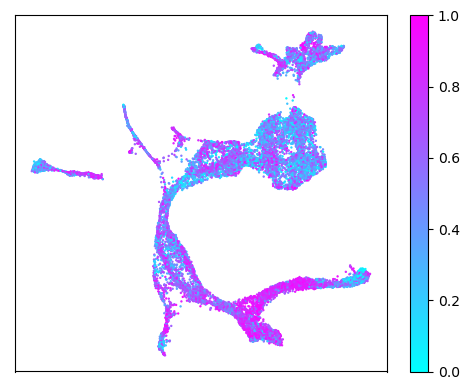

In [33]:
fig, ax = plt.subplots()

sc = ax.scatter(x=adata_nmp_deepvel.obsm['X_umap'][:,0], y=adata_nmp_deepvel.obsm['X_umap'][:,1], s=0.5, c=color_col, 
                                    cmap='cool', vmin=0, vmax=1)

for child in ax.get_children():
            if isinstance(child, matplotlib.collections.Collection):
                child.set_rasterized(True)
                
plt.colorbar(sc)
plt.xticks([])
plt.yticks([])

plt.gcf().set_size_inches(5, 4)
plt.tight_layout()

#plt.axis('off')

#plt.savefig('deepvelo_vs_velocyto_umap.pdf', bbox_inches='tight', pad_inches=0, dpi=500)

#plt.show()

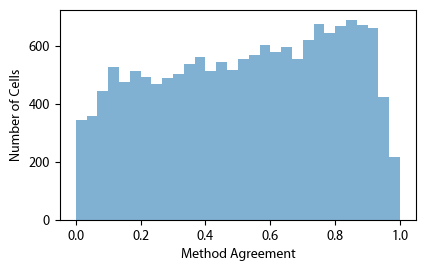

In [49]:
plt.figure(figsize=(2, 1.5))

plt.hist(nmp_cellcelldf['deepVel_scvDet'], bins=30, color='#80b1d3',
         #range=(-0.3, 0.8)
        )
plt.xlabel('Method Agreement')
plt.ylabel('Number of Cells')

plt.tight_layout()

plt.gcf().set_size_inches(6, 4)

#plt.savefig('figures/histogram_MethodAgreement_Nov3.pdf', format='pdf')
plt.show()

# Grid of UMAPs, pairwise method comparisons for one dataset

In [22]:
def grid_UMAP(adata, melted_df):

# Generate sample data
    n = 5  # Number of methods

    methods = pd.unique(melted_df[['Method A', 'Method B']].values.ravel())

    # Create the grid
    fig, axs = plt.subplots(n, n, figsize=(12, 12))

    # Iterate over each cell in the grid
    for i in range(n):
        for j in range(n):
            # Create a UMAP plot for each cell
            locx = n - i -1
            locy = n-j-1
            methodA = methods[i]
            methodB = methods[j]

            color_col = melted_df[(melted_df['Method A'] == methodA) & (melted_df['Method B'] == methodB)]['Value'].tolist()



            # Plot the UMAP
            axs[locx, locy].scatter(x=adata.obsm['X_umap'][:,0], y=adata.obsm['X_umap'][:,1], s=0.5, alpha=0.5, c=color_col, 
                                    cmap='viridis', vmin=0, vmax=1)
            axs[locx, locy].set_xticks([])
            axs[locx, locy].set_yticks([])
            axs[i, j].set_title(f"{methodA} vs. {methodB}", fontsize=5)

            if locx == 4:
                axs[locx, locy].set_xlabel(f"{methods[locy]}", fontsize=8)

            if locy == 0:
                axs[locx, locy].set_ylabel(f"{methods[locx]}", fontsize=8)


    # Adjust spacing between subplots
    plt.tight_layout()

    #plt.savefig('Bigplot_nmp_comparison_mockup_Jul17.png', dpi=500)

    # Show the plot
    


/tmp/ipykernel_1523562/2082163403.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  axs[locx, locy].scatter(x=adata.obsm['X_umap'][:,0], y=adata.obsm['X_umap'][:,1], s=0.5, alpha=0.5, c=color_col,
/tmp/ipykernel_1523562/2082163403.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  axs[locx, locy].scatter(x=adata.obsm['X_umap'][:,0], y=adata.obsm['X_umap'][:,1], s=0.5, alpha=0.5, c=color_col,
/tmp/ipykernel_1523562/2082163403.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  axs[locx, locy].scatter(x=adata.obsm['X_umap'][:,0], y=adata.obsm['X_umap'][:,1], s=0.5, alpha=0.5, c=color_col,
/tmp/ipykernel_1523562/2082163403.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  axs[locx, locy].scatter(x=adata.obsm['X_umap'][:,0], y=adata.obsm

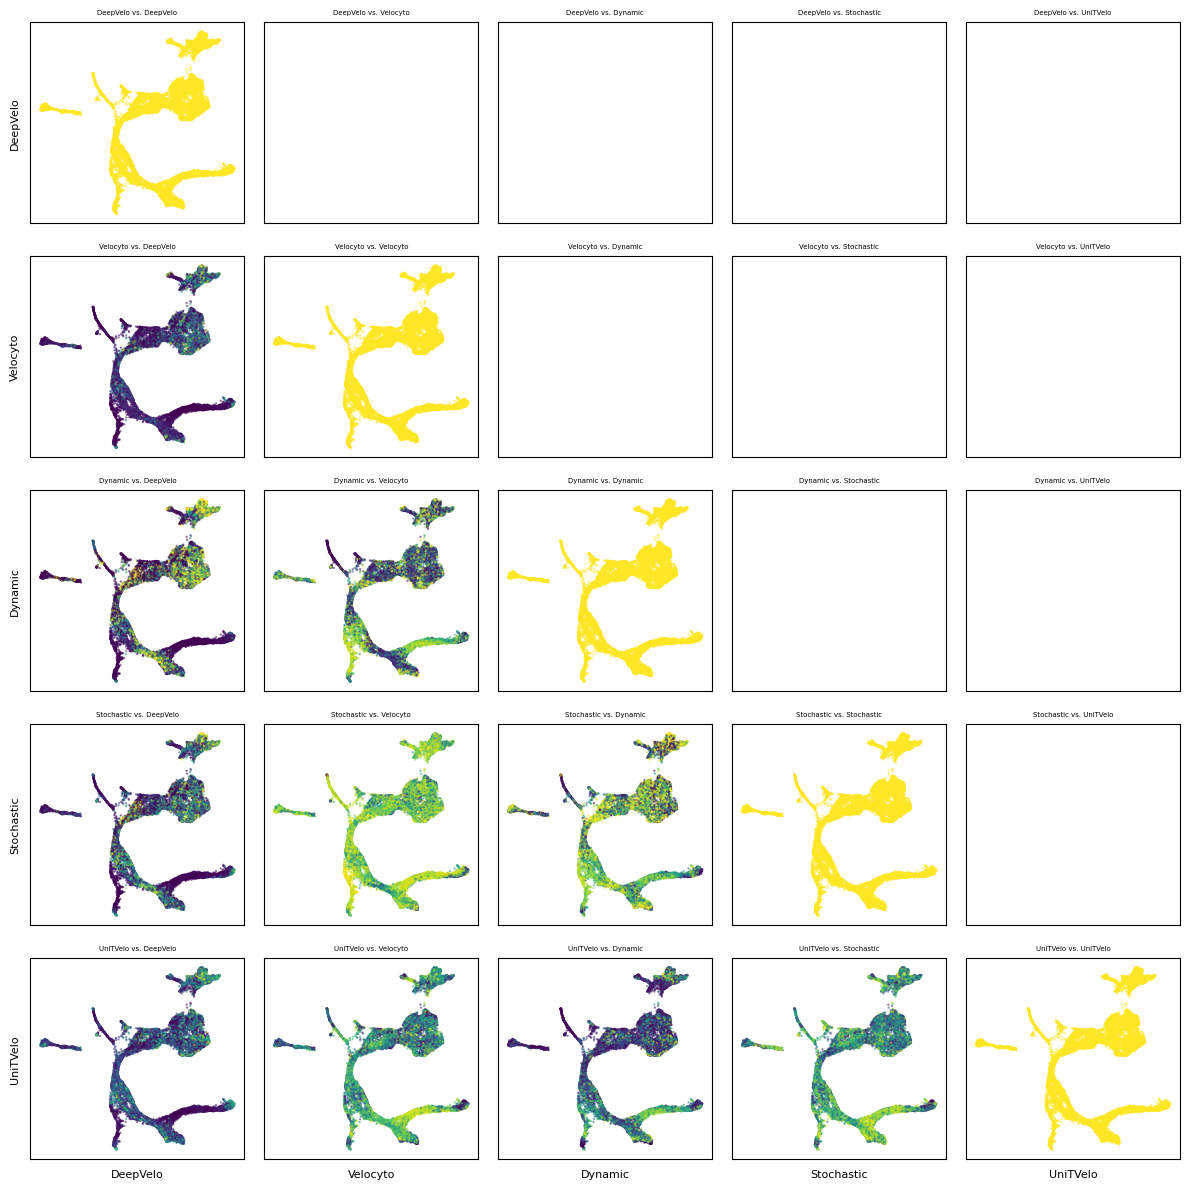

In [24]:
grid_UMAP(adata_nmp_deepvel, melted_nmp)

#plt.savefig('figures/gridpairplots/UMAP_zfNMP_metric2_Aug8.png', dpi=500)

plt.show()

# Grid of pairwise boxplots for all datasets

In [20]:
def grid_boxplot_multidataset(melted_df, melted_df2, melted_df3, mycolors=[], mylabels=[]):

    # Generate sample data
    n = 5  # Number of methods

    methods = pd.unique(melted_df[['Method A', 'Method B']].values.ravel())

    # Create the grid
    fig, axs = plt.subplots(n, n, figsize=(10, 8))

    # Iterate over each cell in the grid
    for i in range(n):
        for j in range(n):
            # Create a UMAP plot for each cell
            locx = n - i -1
            locy = n-j-1
            methodA = methods[i]
            methodB = methods[j]


            color_col = melted_df[(melted_df['Method A'] == methodA) & (melted_df['Method B'] == methodB)]['Value'].tolist()
            color_col2 = melted_df2[(melted_df2['Method A'] == methodA) & (melted_df2['Method B'] == methodB)]['Value'].tolist()
            color_col3 = melted_df3[(melted_df3['Method A'] == methodA) & (melted_df3['Method B'] == methodB)]['Value'].tolist()
            
            data = [color_col, color_col2, color_col3]



            # Plot the UMAP
            
           
            boxprops = dict(color='black')  # Customize box color
            medianprops = dict(color='black') 
            flierprops = dict(marker='o', markersize=1, markeredgecolor='black', markeredgewidth=0.2)


            boxplot = axs[locx, locy].boxplot(x=data, patch_artist = True, 
                                    boxprops=boxprops, medianprops=medianprops, flierprops=flierprops)
            
            
            colors = mycolors  # List of colors for each box
            for patch, color in zip(boxplot['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_edgecolor('black')
        
            axs[locx, locy].set_ylim(-0.1, 1.1)
            axs[locx, locy].set_xticks([])
            axs[locx, locy].set_yticks([0, 0.5, 1])

            if locx == 4:
                axs[locx, locy].set_xlabel(f"{methods[locy]}", fontsize=8)

            if locy == 0:
                axs[locx, locy].set_ylabel(f"{methods[locx]}", fontsize=8)




    legend_labels = mylabels
    legend_patches = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, legend_labels)]
    plt.legend(handles=legend_patches, loc='upper right')

    plt.ylim(0.05, 1)

    # Adjust spacing between subplots
    plt.tight_layout()

    #plt.savefig('Bigplot_nmp_comparison_mockup_Jul17.png', dpi=500)

    # Show the plot
    


In [25]:
melted_nmp = get_melted_DF(nmp_cellcelldf)

In [26]:
melted_zf24 = get_melted_DF(zf24_cellcelldf)

In [27]:
melted_pan = get_melted_DF(pancreas_cellcelldf)

In [28]:
dataset_palette = {'ZF NMP': 'orchid', 'Pancreas': 'forestgreen', 'ZF Full Embryo 24hpf': 'dodgerblue'}

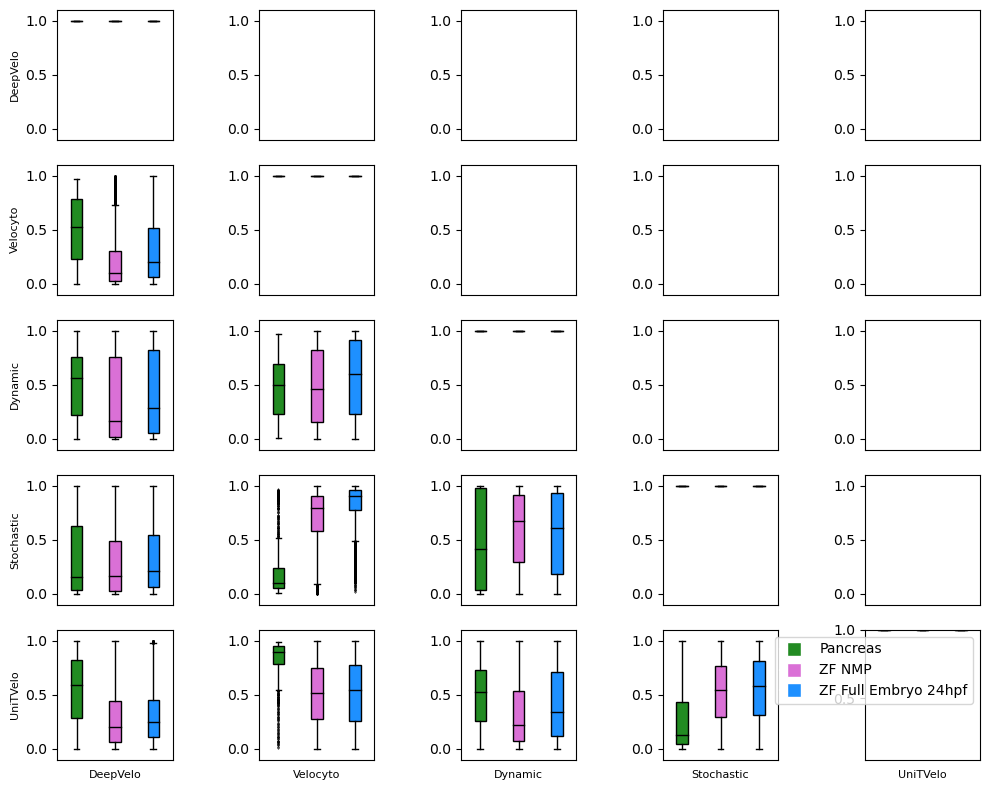

In [29]:
grid_boxplot_multidataset(melted_pan, melted_nmp, melted_zf24, ['forestgreen', 'orchid', 'dodgerblue'], ['Pancreas', 'ZF NMP', 'ZF Full Embryo 24hpf'])

#plt.savefig('figures/gridpairplots/boxplot_metric2_Aug8.pdf')

plt.show()

# Heatmap of pairwise similarity for specific clusters/celltypes

In [56]:
def heatmap_DF_median_comparison(df = pd.DataFrame, dropcols = ['']):
    
    melted_df = df.drop(dropcols, axis=1).copy().melt(id_vars='cell_ID', var_name='Methods', value_name='Value')

    # Split the 'Methods' column into separate 'Method A' and 'Method B' columns
    melted_df[['Method A', 'Method B']] = melted_df['Methods'].str.split('_', expand=True)
        
    a_list = melted_df['Method A'].unique().tolist()
    b_list = melted_df['Method B'].unique().tolist()
        
    fulllist = list(set(a_list + b_list))
    
    extrarows = []    
    for method in fulllist:
        
        myrow = {'cell_ID': 'extra', 'Methods': method + '_' + method, 'Value': 1, 'Method A': method, 'Method B': method}
        extrarows.append(myrow)
        
    melted_df = melted_df.append(extrarows, ignore_index = True)
        
        
    pivot_df = melted_df.groupby(['Method A', 'Method B'])['Value'].median().unstack().copy()
    
    mydf = pivot_df.rename(columns={'deepVel': 'DeepVelo', 'scvDet': 'Velocyto', 'scvDyn': 'Dynamic', 'scvSto': 'Stochastic', 'uniTV': 'UniTVelo'})

    # Rename row indices
    mydf = mydf.rename(index={'deepVel': 'DeepVelo', 'scvDet': 'Velocyto', 'scvDyn': 'Dynamic', 'scvSto': 'Stochastic', 'uniTV': 'UniTVelo'})

    
    return mydf
        

In [34]:
def heatmap_DF_mean_comparison(df = pd.DataFrame, dropcols = ['']):
    
    melted_df = df.drop(dropcols, axis=1).copy().melt(id_vars='cell_ID', var_name='Methods', value_name='Value')

    # Split the 'Methods' column into separate 'Method A' and 'Method B' columns
    melted_df[['Method A', 'Method B']] = melted_df['Methods'].str.split('_', expand=True)
        
    a_list = melted_df['Method A'].unique().tolist()
    b_list = melted_df['Method B'].unique().tolist()
        
    fulllist = list(set(a_list + b_list))
    
    extrarows = []    
    for method in fulllist:
        
        myrow = {'cell_ID': 'extra', 'Methods': method + '_' + method, 'Value': 1, 'Method A': method, 'Method B': method}
        extrarows.append(myrow)
        
    melted_df = melted_df.append(extrarows, ignore_index = True)
        
        
    pivot_df = melted_df.groupby(['Method A', 'Method B'])['Value'].mean().unstack().copy()
    
    mydf = pivot_df.rename(columns={'deepVel': 'DeepVelo', 'scvDet': 'Velocyto', 'scvDyn': 'Dynamic', 'scvSto': 'Stochastic', 'uniTV': 'UniTVelo'})

    # Rename row indices
    mydf = mydf.rename(index={'deepVel': 'DeepVelo', 'scvDet': 'Velocyto', 'scvDyn': 'Dynamic', 'scvSto': 'Stochastic', 'uniTV': 'UniTVelo'})

    
    return mydf

In [37]:
def metric2_DF(metricdf = pd.DataFrame, clusteradata = [[]]):

    new_metric2df = metricdf.copy()
    new_metric2df.rename(columns={'cell_ID': 'cell_id'}, inplace=True)
    
    new_metric2df.set_index('cell_id', inplace=True)
    
    metric2DF = pd.concat([new_metric2df, clusteradata.obs[['clusters']]], axis=1)
    
    return metric2DF

## ZF 24hpf Embryo

In [38]:
df24 = metric2_DF(zf24_cellcelldf, adata_zf_deepvel)

In [39]:
df_zf = df24.groupby('clusters').mean()
df_zf.reset_index(inplace=True)
df_zf['range'] = df_zf.max(axis=1) - df_zf.min(axis=1)

In [40]:
df_zf.sort_values('range')

,clusters,deepVel_scvDet,deepVel_scvDyn,deepVel_scvSto,deepVel_uniTV,scvDet_scvDyn,scvDet_scvSto,scvDet_uniTV,scvDyn_scvSto,scvDyn_uniTV,scvSto_uniTV,range
15,15,0.811804,0.743339,0.738964,0.646333,0.738074,0.944323,0.692911,0.665004,0.738712,0.641961,0.302361
20,20,0.943266,0.874520,0.898260,0.643210,0.891934,0.848015,0.621305,0.821920,0.601666,0.626834,0.341600
6,6,0.492409,0.378217,0.415856,0.273394,0.535509,0.719477,0.385904,0.670639,0.553849,0.418270,0.446084
18,18,0.868887,0.677897,0.831407,0.749896,0.604135,0.950525,0.770040,0.594623,0.502333,0.752984,0.448192
2,2,0.568225,0.442119,0.552339,0.381217,0.761331,0.836522,0.531079,0.624211,0.567088,0.488408,0.455305
8,8,0.516533,0.449087,0.400733,0.442931,0.648425,0.887509,0.467359,0.639935,0.476004,0.432480,0.486776
10,10,0.616637,0.403809,0.559418,0.263419,0.738897,0.764673,0.406524,0.741233,0.492220,0.426582,0.501254
13,13,0.783946,0.545414,0.652432,0.511234,0.524987,0.796495,0.447918,0.383862,0.394395,0.283367,0.513129
19,19,0.689390,0.443429,0.717509,0.559582,0.617214,0.968789,0.740672,0.587865,0.517187,0.705590,0.525361
9,9,0.527350,0.392943,0.498306,0.325913,0.739222,0.863306,0.510437,0.721949,0.530020,0.497866,0.537393


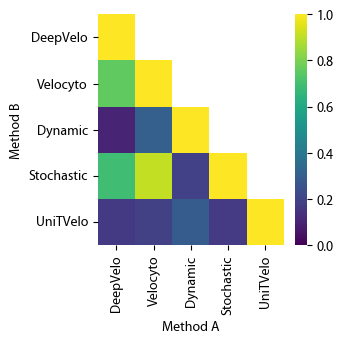

In [59]:
plt.rcParams['font.family'] = myfont.get_name()
plt.rcParams['font.size'] = 10
plt.figure(figsize=(3, 3))

minidf = df24[df24['clusters'] == '1'].copy()
minidf['cell_ID'] = minidf.index

minidf_testDF = heatmap_DF_median_comparison(minidf, ['analysis_type', 'dataset', 'clusters'])
sns.heatmap(minidf_testDF.T, cmap='viridis', vmin=0, vmax=1)


#plt.savefig('zf24_cluster1_Viridis_heatmap_metric2_Sep5.pdf')

plt.show()

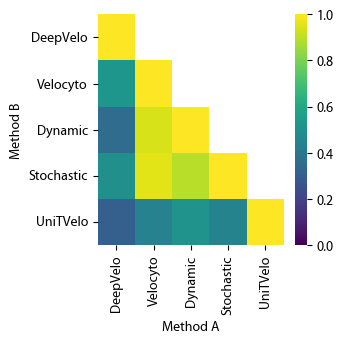

In [57]:
plt.rcParams['font.family'] = myfont.get_name()
plt.rcParams['font.size'] = 10
plt.figure(figsize=(3, 3))

minidf = df24[df24['clusters'] == '9'].copy()
minidf['cell_ID'] = minidf.index

minidf_testDF = heatmap_DF_median_comparison(minidf, ['analysis_type', 'dataset', 'clusters'])
sns.heatmap(minidf_testDF.T, cmap='viridis', vmin=0, vmax=1)


#plt.savefig('zf24_cluster9_Viridis_heatmap_metric2_Sep5.pdf')

plt.show()

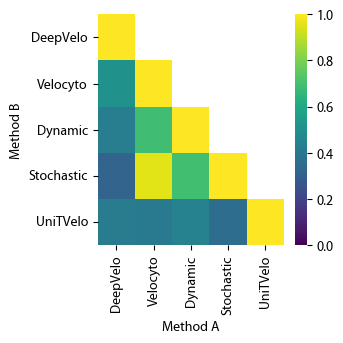

In [58]:
plt.rcParams['font.family'] = myfont.get_name()
plt.rcParams['font.size'] = 10
plt.figure(figsize=(3, 3))

minidf = df24[df24['clusters'] == '8'].copy()
minidf['cell_ID'] = minidf.index

minidf_testDF = heatmap_DF_median_comparison(minidf, ['analysis_type', 'dataset', 'clusters'])
sns.heatmap(minidf_testDF.T, cmap='viridis', vmin=0, vmax=1)


#plt.savefig('zf24_cluster8_Viridis_heatmap_metric2_Sep5.pdf')

plt.show()

## Heatmap code for ZF NMP clusters

In [44]:
new_nmpmetric2 = nmp_cellcelldf.copy()
new_nmpmetric2.rename(columns={'cell_ID': 'cell_id'}, inplace=True)

# Set 'cell_id' column as the index
new_nmpmetric2.set_index('cell_id', inplace=True)

In [45]:
nmp_metric2 = pd.concat([new_nmpmetric2, adata_nmp_deepvel.obs[['clusters']]], axis=1)

In [46]:
df = nmp_metric2.groupby('clusters').mean()
df[df.index == '21']
df.reset_index(inplace=True)

In [48]:
df['range'] = df.max(axis=1) - df.min(axis=1)
df.head()

,clusters,deepVel_scvDet,deepVel_scvDyn,deepVel_scvSto,deepVel_uniTV,scvDet_scvDyn,scvDet_scvSto,scvDet_uniTV,scvDyn_scvSto,scvDyn_uniTV,scvSto_uniTV,range
0,0,0.447010,0.202954,0.424353,0.316101,0.602714,0.649093,0.248002,0.441553,0.268016,0.152874,0.496219
1,1,0.537212,0.358182,0.475998,0.302512,0.697022,0.716107,0.398137,0.621883,0.308204,0.208289,0.507818
2,10,0.677167,0.362801,0.693249,0.227084,0.678105,0.672598,0.393704,0.316458,0.500558,0.145837,0.547412
3,11,0.614005,0.396111,0.598768,0.258619,0.731830,0.763156,0.306943,0.633263,0.245761,0.104734,0.658422
4,12,0.375308,0.310197,0.442874,0.353396,0.400214,0.671053,0.287987,0.430314,0.609624,0.322446,0.383066


In [51]:
minidf = nmp_metric2[nmp_metric2['clusters'] == '21'].copy()
minidf['cell_ID'] = minidf.index

minidf.head()

,deepVel_scvDet,deepVel_scvDyn,deepVel_scvSto,deepVel_uniTV,scvDet_scvDyn,scvDet_scvSto,scvDet_uniTV,scvDyn_scvSto,scvDyn_uniTV,scvSto_uniTV,analysis_type,dataset,clusters,cell_ID
cell_id,,,,,,,,,,,,,,
TDR18_AGGGTCCCAATTGAAG-1,0.915850,0.637467,0.751388,0.042241,0.795865,0.901789,0.000924,0.959426,0.000415,0.000306,cell_cell,nmp,21,TDR18_AGGGTCCCAATTGAAG-1
TDR18_CAACAGTGTAGGCTCC-1,0.507856,0.415861,0.446326,0.031259,0.954385,0.986484,0.023992,0.947815,0.034651,0.018731,cell_cell,nmp,21,TDR18_CAACAGTGTAGGCTCC-1
TDR18_CATCGGGCAGAGGTAC-1,0.713513,0.666720,0.723428,0.059512,0.797242,0.980614,0.074279,0.880949,0.070375,0.072210,cell_cell,nmp,21,TDR18_CATCGGGCAGAGGTAC-1
TDR18_CGTGATATCAACCTTT-1,0.223876,0.299187,0.211749,0.102879,0.918148,0.974006,0.007510,0.900175,0.034301,0.003577,cell_cell,nmp,21,TDR18_CGTGATATCAACCTTT-1
TDR18_CTGATCCTCTGTGCTC-1,0.163176,0.295922,0.187783,0.589917,0.890896,0.936498,0.046268,0.911993,0.110867,0.043378,cell_cell,nmp,21,TDR18_CTGATCCTCTGTGCTC-1


In [60]:
adata_nmp_deepvel.obs[adata_nmp_deepvel.obs['clusters'] == '18']['Cells_Annotations'].value_counts()

Endoderm         348
FloorPlate         0
Hindbrain          0
LateralPlate       0
Muscle             0
Myotome            0
NMPs               0
NeuralCrest        0
NeuralTube         0
Notochord          0
PSM                0
PharyngealArc      0
Somites            0
Name: Cells_Annotations, dtype: int64

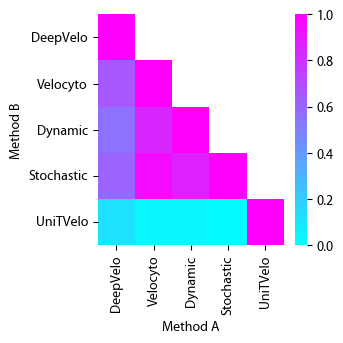

In [52]:
plt.rcParams['font.family'] = myfont.get_name()
plt.rcParams['font.size'] = 10
plt.figure(figsize=(3, 3))

minidf = nmp_metric2[nmp_metric2['clusters'] == '21'].copy()
minidf['cell_ID'] = minidf.index

minidf_testDF = heatmap_DF_mean_comparison(minidf, ['analysis_type', 'dataset', 'clusters'])
sns.heatmap(minidf_testDF.T, cmap='cool', vmin=0, vmax=1)


#plt.savefig('cluster21_lateralplate_cool_nmp_boxplot_metric2_May20.pdf')

plt.show()